# Synopsis

This project aims to build a deep learning model using PyTorch to classify images using convolutional neural networks. The model is trained on the well-known CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). The techniques of transfer learning (from the VGG16 model with batch normalization) and data augmentation were used to enhance the model's accuracy. A final accuracy of 87.0500 % was obtained on the test set.

# Setup

Install the torchinfo library to obtain model summaries.

In [1]:
! pip install torchinfo

Import the libraries and methods needed for the project.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.nn import (
    Sequential,
    Linear,
    ReLU,
    Dropout,
    CrossEntropyLoss
)
from torchvision.transforms import (
    Compose,
    Resize,
    RandomRotation,
    RandomHorizontalFlip,
    RandomCrop,
    ToTensor,
    Normalize
)
from torchvision.datasets import CIFAR10
from torch.utils.data import (
    random_split,
    DataLoader
)
from torchvision.models import vgg16_bn
from torchinfo import summary
from torch.optim import Adam
from copy import deepcopy

# Preprocessing

Lay out the image size, means and standard deviations expected by the pretrained model.

In [3]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]

Define transforms for the training set.

In [4]:
train_transforms = Compose([
    Resize(size = pretrained_size),
    RandomRotation(degrees = 5),
    RandomHorizontalFlip(p = 0.5),
    RandomCrop(size = pretrained_size, 
               padding = 10),
    ToTensor(),
    Normalize(mean = pretrained_means,
              std = pretrained_stds)
])

Define transforms for the test set.

In [5]:
test_transforms = Compose([
    Resize(size = pretrained_size),
    ToTensor(),
    Normalize(mean = pretrained_means,
              std = pretrained_stds)
])

# Load the data

Load the data, performing the predefined transforms.

In [6]:
ROOT = ".data"

raw_train_data = CIFAR10(root = ROOT,
                         train = True,
                         download = True,
                         transform = train_transforms)

test_data = CIFAR10(root = ROOT,
                    train = False,
                    download = True,
                    transform = test_transforms)

0it [00:00, ?it/s]

Extracting .data/cifar-10-python.tar.gz to .data
Files already downloaded and verified


# Data partitioning

Carve out a validation set from the raw training set. 90 % of the raw training set forms the final training set and the other 10 % forms the validation set.

In [7]:
SPLIT_FRACTION = 0.9

n_train_examples = int(len(raw_train_data) * SPLIT_FRACTION)
n_valid_examples = len(raw_train_data) - n_train_examples

train_data, valid_data = random_split(dataset = raw_train_data,
                                      lengths = [n_train_examples, n_valid_examples])

Ensure that the validation set uses the same transforms as the test set.

In [8]:
valid_data = deepcopy(x = valid_data)
valid_data.dataset.transform = test_transforms

Check the number of examples in each set.

In [9]:
print(f"Number of examples in the training set: {len(train_data)}")
print(f"Number of examples in the validation set: {len(valid_data)}")
print(f"Number of examples in the test set: {len(test_data)}")

Number of examples in the training set: 45000
Number of examples in the validation set: 5000
Number of examples in the test set: 10000


# Check transforms

Plot 25 sample images to check whether the proposed transforms are sensible.

In [10]:
def normalize_image(image):
    
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min,
                 max = image_max)
    image.subtract_(image_min).div_(image_max - image_min + 1e-5)
    
    return image

In [11]:
def plot_images(images, 
                labels,
                classes,
                normalize = True):
    
    num_images = len(images)
    
    rows = int(np.sqrt(num_images))
    columns = int(np.sqrt(num_images))
    
    fig = plt.figure(figsize = [10, 10])
    
    for i in range(rows * columns):
        
        ax = fig.add_subplot(rows, columns, (i+1))
        
        image = images[i]
        
        if normalize:
            image = normalize_image(image)
            
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis("off")

In [12]:
N_IMAGES = 25

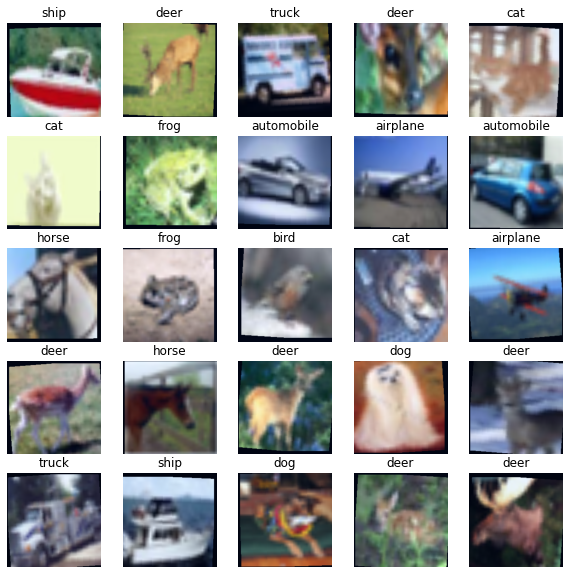

In [13]:
images, labels = zip(*[(image, label) for (image, label) in 
                          [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

# Form data iterators

Form iterators for the training, validation and test sets using a desired batch size.

In [14]:
BATCH_SIZE = 128

In [15]:
train_iterator = DataLoader(dataset = train_data,
                            shuffle = True,
                            batch_size = BATCH_SIZE)

valid_iterator = DataLoader(dataset = valid_data,
                            batch_size = BATCH_SIZE)

test_iterator = DataLoader(dataset = test_data,
                           batch_size = BATCH_SIZE)

# Define the model

Import a pretrained VGG16 model with batch normalization.

In [16]:
model = vgg16_bn(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Inspect the layers present in the model.

In [17]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Ensure that the convolutional feature-extracting base is frozen and the classifier head is unfrozen. Setting requires_grad to False freezes the corresponding layer and setting it to True unfreezes it. The adaptive average pooling layer contains no parameters.

In [18]:
for param in model.features.parameters():
    param.requires_grad = False

In [19]:
for param in model.classifier.parameters():
    param.requires_grad = True

The pretrained model was trained on the ImageNet dataset, which had 1000 classes. Hence, the final layer in the classifier has 1000 output features. Inspect this last layer.

In [20]:
model.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

Since I am currently building a model on the CIFAR-10 dataset, which has 10 classes, I want this final layer to have 10 output features. Replace the final layer with a linear layer which has 10 output features. The newly added layer will have requires_grad set to True and will be trainable.

In [21]:
N_CLASSES = 10
IN_FEATURES = model.classifier[-1].in_features

In [22]:
final_layer = Linear(in_features = IN_FEATURES, 
                     out_features = N_CLASSES)

In [23]:
model.classifier[-1] = final_layer

Check that the modified classifier does have 10 output features.

In [24]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

Summarize the final overall model.

In [25]:
summary(model,
        input_size = [BATCH_SIZE, 3, 224, 224],
        device = "cuda")

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [128, 512, 7, 7]          --
│    └─Conv2d: 2-1                       [128, 64, 224, 224]       (1,792)
│    └─BatchNorm2d: 2-2                  [128, 64, 224, 224]       (128)
│    └─ReLU: 2-3                         [128, 64, 224, 224]       --
│    └─Conv2d: 2-4                       [128, 64, 224, 224]       (36,928)
│    └─BatchNorm2d: 2-5                  [128, 64, 224, 224]       (128)
│    └─ReLU: 2-6                         [128, 64, 224, 224]       --
│    └─MaxPool2d: 2-7                    [128, 64, 112, 112]       --
│    └─Conv2d: 2-8                       [128, 128, 112, 112]      (73,856)
│    └─BatchNorm2d: 2-9                  [128, 128, 112, 112]      (256)
│    └─ReLU: 2-10                        [128, 128, 112, 112]      --
│    └─Conv2d: 2-11                      [128, 128, 112, 11

# Loss function and optimizer

Define the loss function and the optimizer to be used.

In [26]:
loss_fn = CrossEntropyLoss()
optimizer = Adam(params = model.parameters(),
                 lr = 0.001)

# Copy the model to the GPU

In [27]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [28]:
print(f"Using {device} device")

Using cuda device


In [29]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Define the training function

Define a function to train the model and simultaneously validate it, across a desired number of epochs.

In [30]:
def train(train_iterator,
          valid_iterator,
          model,
          loss_fn,
          optimizer,
          device,
          n_epochs = 5):
    
    # Initialize the history list which will contain all losses and metrics
    
    history_list = []
    
    for i in range(n_epochs):
        
        # Start setting up the training procedure
        
        print(f"Epoch {i+1}")
        print("-------------------------------")
    
        train_size = len(train_iterator.dataset)
        n_train_batches = len(train_iterator)
        train_loss = 0
        average_train_loss = 0
        train_n_correct = 0
        train_accuracy = 0
    
        # Set the model to training mode
        
        model.train()
    
        for train_batch, (X, y) in enumerate(train_iterator):
        
            # Copy the tensors to the GPU
        
            X = X.to(device)
            y = y.to(device)
            
            # Reset the gradients of the model parameters to zero
            
            optimizer.zero_grad()
            
            # Obtain the model prediction and loss
            
            pred = model(X)
            loss = loss_fn(pred, y)
            
            # Backpropagate the loss and deposit each gradient in place
            
            loss.backward()
            
            # Adjust the parameters using the gradients collected in the backward pass
            
            optimizer.step()
            
            # Increment the validation loss and the number of correctly labeled instances
            # Build up these aggregate values instance by instance
                
            train_loss += loss.item()
            train_n_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
            # Display the training loss after every hundredth batch is trained
        
            if train_batch % 100 == 0:
                loss = loss.item()
                current_instance = train_batch * len(X)
                print(f"Loss: {loss:.6f} [{current_instance:5f} / {train_size:5f}]")
                
        # Obtain average training loss and accuracy for the entire epoch
        
        average_train_loss = train_loss / n_train_batches
        train_accuracy = train_n_correct / train_size
                
        # After training is finished, start validation
        
        valid_size = len(valid_iterator.dataset)
        n_valid_batches = len(valid_iterator)
        valid_loss = 0
        average_valid_loss = 0
        valid_n_correct = 0
        valid_accuracy = 0
        
        with torch.no_grad():
            
            # Set the model to evaluation mode
            
            model.eval()
            
            for X, y in valid_iterator:
                
                # Copy the tensors to the GPU
                
                X = X.to(device)
                y = y.to(device)
                
                # Obtain the model prediction and loss
                
                pred = model(X)
                loss = loss_fn(pred, y)
                
                # Increment the validation loss and the number of correctly labeled instances
                # Build up aggregate values instance by instance
                
                valid_loss += loss.item()
                valid_n_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                
        # Obtain average validation loss and accuracy for the entire epoch
        
        average_valid_loss = valid_loss / n_valid_batches
        valid_accuracy = valid_n_correct / valid_size
        
        print("Validation error:")
        print(f"Accuracy: {valid_accuracy:.6f}, Average loss: {average_valid_loss:.6f}")
        print()
        
        history_list.append([average_train_loss, average_valid_loss, train_accuracy, valid_accuracy])
    
    # Display a message indicating training has finished
    
    print()
    print("Done!")
    
    # Create a data frame containing the entire training and validation history
    
    history = pd.DataFrame(data = history_list,
                           columns = ["average_train_loss", "average_valid_loss", 
                                      "train_accuracy", "valid_accuracy"])
    
    return model, history

# Train the model

Pick a suitable number of epochs.

In [31]:
n_epochs = 20

Run the training function.

In [32]:
model, history = train(train_iterator = train_iterator,
                       valid_iterator = valid_iterator,
                       model = model,
                       loss_fn = loss_fn,
                       optimizer = optimizer,
                       device = device,
                       n_epochs = n_epochs)

Epoch 1
-------------------------------
Loss: 2.434332 [0.000000 / 45000.000000]
Loss: 0.868250 [12800.000000 / 45000.000000]
Loss: 0.799944 [25600.000000 / 45000.000000]
Loss: 0.652485 [38400.000000 / 45000.000000]
Validation error:
Accuracy: 0.809000, Average loss: 0.566040

Epoch 2
-------------------------------
Loss: 0.769252 [0.000000 / 45000.000000]
Loss: 0.766743 [12800.000000 / 45000.000000]
Loss: 0.738539 [25600.000000 / 45000.000000]
Loss: 0.375083 [38400.000000 / 45000.000000]
Validation error:
Accuracy: 0.848000, Average loss: 0.470199

Epoch 3
-------------------------------
Loss: 0.465486 [0.000000 / 45000.000000]
Loss: 0.500572 [12800.000000 / 45000.000000]
Loss: 0.381555 [25600.000000 / 45000.000000]
Loss: 0.553747 [38400.000000 / 45000.000000]
Validation error:
Accuracy: 0.841200, Average loss: 0.481155

Epoch 4
-------------------------------
Loss: 0.626594 [0.000000 / 45000.000000]
Loss: 0.496887 [12800.000000 / 45000.000000]
Loss: 0.688359 [25600.000000 / 45000.000

Plot the training and validation loss.

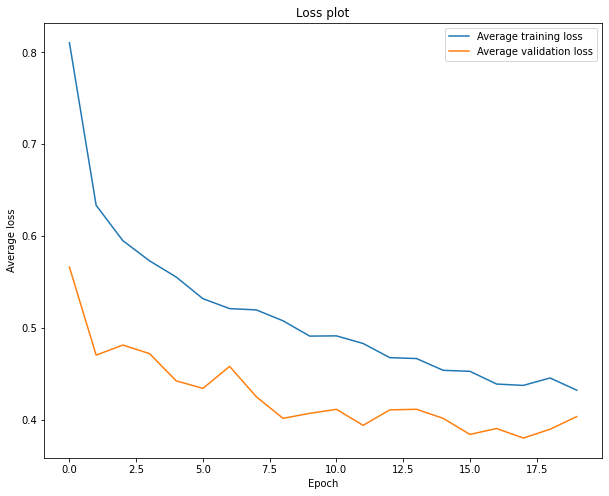

In [33]:
plt.figure(figsize = [10, 8])
plt.plot(history["average_train_loss"],
         label = "Average training loss")
plt.plot(history["average_valid_loss"],
         label = "Average validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average loss")
plt.title("Loss plot")
plt.show()

Plot the training and validation accuracy.

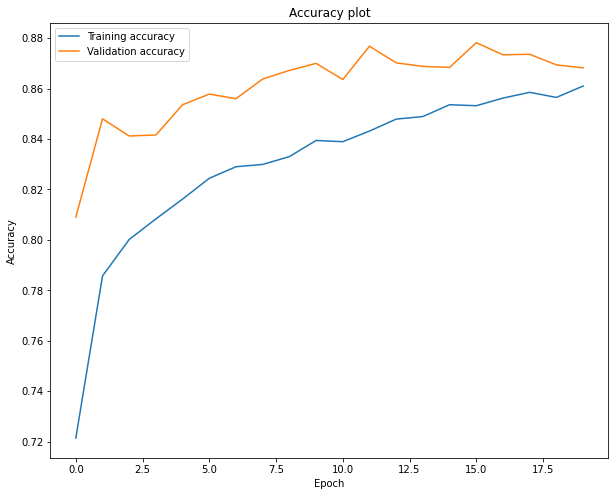

In [34]:
plt.figure(figsize = [10, 8])
plt.plot(history["train_accuracy"],
         label = "Training accuracy")
plt.plot(history["valid_accuracy"],
         label = "Validation accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy plot")
plt.show()

# Evaluate the model

Perform a final evaluation of the model on the test set. First, define a function to carry out the same.

In [35]:
def evaluate(test_iterator, 
             model, 
             loss_fn,
             device):
    
    size = len(test_iterator.dataset)
    num_batches = len(test_iterator)
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for X, y in test_iterator:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    average_loss = test_loss / num_batches
    accuracy = correct / size
    
    print("Test error:")
    print(f"Accuracy: {accuracy:.6f}, Average loss: {average_loss:.6f}")

Then, run the function on the model which has just been trained.

In [36]:
evaluate(test_iterator = test_iterator,
         model = model,
         loss_fn = loss_fn,
         device = device)

Test error:
Accuracy: 0.870500, Average loss: 0.395295


# Save the model

Save the model to disk.

In [37]:
torch.save(model, "pytorch-vgg16-cifar-10-model.pth")